In [35]:
# Import the necessary packages
import torch
import torch.nn as nn
from torch.optim import Adam
from torch.utils.data import Dataset, DataLoader
import torchvision
from torchvision import transforms, models, datasets
from torchsummary import summary
import numpy as np
import cv2
import matplotlib.pyplot as plt
import pandas as pd
from glob import glob
import time
import random
import os

### Multi task learning(predicting age and gender from an image) using VGG16

In [2]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

In [3]:
trn_df = pd.read_csv("./data/Age_Gender_data/fairface-labels-train.csv")
val_df = pd.read_csv("./data/Age_Gender_data/fairface-labels-val.csv")

In [4]:
trn_df.head()

,file,age,gender,race,service_test
0,train/1.jpg,59,Male,East Asian,True
1,train/2.jpg,39,Female,Indian,False
2,train/3.jpg,11,Female,Black,False
3,train/4.jpg,26,Female,Indian,True
4,train/5.jpg,26,Female,Indian,True


In [26]:
val_df.head()

,file,age,gender,race,service_test
0,val/1.jpg,11,Male,East Asian,False
1,val/2.jpg,51,Female,East Asian,True
2,val/3.jpg,37,Male,White,True
3,val/4.jpg,25,Female,Latino_Hispanic,True
4,val/5.jpg,24,Male,Southeast Asian,False


In [5]:
IMAGE_SIZE = 224  # The target size to which images will be resized

class GenderAgeClass(Dataset):
    def __init__(self, df, tfms=None):
        """
        Initialize the dataset.
        - df: DataFrame containing the dataset, where each row has file paths for images and labels for gender and age.
        - tfms: Optional transformations to apply to the images. (Not used in the code provided)
        """
        self.df = df  # Store the DataFrame containing image paths and labels
        # Normalization values for pretrained models like VGG16 (ImageNet mean and std)
        self.normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])

    def __len__(self):
        """
        Returns the number of samples in the dataset.
        """
        return len(self.df)

    def __getitem__(self, ix):
        """
        Fetches the data (image, age, gender) for a specific index.
        - ix: Index to access a specific row in the DataFrame
        """
        f = self.df.iloc[ix].squeeze()  # Access the row of the DataFrame at index ix
        file = f.file  # Get the file path for the image
        gen = f.gender == "Female"  # Assign 1 if female, 0 if male (binary classification)
        age = f.age  # Age value for the sample
        im = cv2.imread("./data/Age_Gender_data/"+file)  # Read the image from the file path using OpenCV
        im = cv2.cvtColor(im, cv2.COLOR_BGR2RGB)  # Convert the image from BGR to RGB (OpenCV loads images in BGR)
        
        # Return the image, age, and gender
        return im, age, gen

    def preprocess_image(self, im):
        """
        Preprocesses the image.
        - im: The raw image to preprocess
        """
        im = cv2.resize(im, (IMAGE_SIZE, IMAGE_SIZE))  # Resize the image to the target size (224x224)
        im = torch.tensor(im).permute(2, 0, 1)  # Convert image to a tensor and change the dimension order from HxWxC to CxHxW
        im = self.normalize(im / 255.)  # Normalize the image using ImageNet mean and std after scaling pixel values to [0, 1]
        return im[None]  # Add an extra dimension (batch dimension) for the image

    def collate_fn(self, batch):
        """
        Custom collate function to process a batch of data.
        - batch: A list of tuples (im, age, gender) for each sample in the batch
        """
        ims, ages, genders = [], [], []  # Empty lists to store processed images, ages, and genders
        
        # Loop through each sample in the batch
        for im, age, gender in batch:
            im = self.preprocess_image(im)  # Preprocess the image
            ims.append(im)  # Add processed image to the list
            ages.append(float(int(age) / 80))  # Normalize the age (assuming age is in the range [0, 80])
            genders.append(float(gender))  # Convert gender (0 or 1) to float and add to the list
        
        # Convert ages and genders to tensors and move them to the device (GPU if available)
        ages, genders = [torch.tensor(x).to(device).float() for x in [ages, genders]]
        
        # Concatenate the images into a single tensor and move it to the device
        ims = torch.cat(ims).to(device)
        
        # Return the batch of images, ages, and genders
        return ims, ages, genders


In [6]:
trn = GenderAgeClass(trn_df)
val = GenderAgeClass(val_df)

In [7]:
# Create a DataLoader for the training dataset (trn)
train_loader = DataLoader(
    trn,  # The dataset (trn) to load data from
    batch_size=32,  # Number of samples in each batch
    shuffle=True,  # Shuffle the dataset at each epoch to ensure randomness
    drop_last=True,  # Drop the last batch if it has fewer than 32 samples (useful for ensuring each batch is of the same size)
    collate_fn=trn.collate_fn  # Custom collate function to handle batching of data (e.g., preprocessing)
)

# Create a DataLoader for the validation/test dataset (val)
test_loader = DataLoader(
    val,  # The dataset (val) to load data from
    batch_size=32,  # Number of samples in each batch
    collate_fn=val.collate_fn  # Custom collate function for validation data
)

# Retrieve the first batch of data from the training DataLoader
a, b, c = next(iter(train_loader))  # `a` = images, `b` = ages, `c` = genders

# Print the shape of the data in the batch
print(a.shape, b.shape, c.shape)


torch.Size([32, 3, 224, 224]) torch.Size([32]) torch.Size([32])


In [8]:
# Define a function to get the model with pre-trained VGG16 and a custom classifier
def get_model():
    # Load the pre-trained VGG16 model (from torchvision)
    SNet = models.vgg16(pretrained=True)
    
    # Freeze the parameters of the pre-trained model to prevent updating them during training
    for param in SNet.parameters():
        param.requires_grad = False
    
    # Modify the average pooling layer of VGG16 to use a custom sequence of layers
    SNet.avgpool = nn.Sequential(
        # Conv2D layer with 512 input channels, 512 output channels, and kernel size of 3
        nn.Conv2d(512, 512, kernel_size=3),
        # Max pooling layer to reduce spatial dimensions by a factor of 2
        nn.MaxPool2d(2),
        # ReLU activation function
        nn.ReLU(),
        # Flatten the output to create a 1D tensor for the fully connected layers
        nn.Flatten()
    )

    # Define the custom classifier class for age and gender classification
    class ageGenderClassifier(nn.Module):
        def __init__(self):
            super(ageGenderClassifier, self).__init__()
            # Intermediate layers to reduce dimensionality and apply non-linear transformations
            self.intermediate = nn.Sequential(
                # First fully connected layer with 2048 input features, 512 output features
                nn.Linear(2048, 512),
                nn.ReLU(),  # ReLU activation
                nn.Dropout(0.4),  # Dropout layer to avoid overfitting
                # Second fully connected layer with 512 input features, 128 output features
                nn.Linear(512, 128),
                nn.ReLU(),  # ReLU activation
                nn.Dropout(0.4),  # Dropout layer
                # Third fully connected layer with 128 input features, 64 output features
                nn.Linear(128, 64),
                nn.ReLU(),  # ReLU activation
            )
            # Define the age classifier layer (output is a single value between 0 and 1)
            self.age_classifier = nn.Sequential(
                nn.Linear(64, 1),
                nn.Sigmoid()  # Sigmoid activation to output values between 0 and 1
            )
            # Define the gender classifier layer (output is a single value between 0 and 1)
            self.gender_classifier = nn.Sequential(
                nn.Linear(64, 1),
                nn.Sigmoid()  # Sigmoid activation to output values between 0 and 1
            )

        # Forward pass through the network
        def forward(self, x):
            x = self.intermediate(x)  # Pass through the intermediate layers
            age = self.age_classifier(x)  # Get age prediction
            gender = self.gender_classifier(x)  # Get gender prediction
            return age, gender  # Return both predictions

    # Replace the original classifier of VGG16 with the custom age and gender classifier
    SNet.classifier = ageGenderClassifier()

    # Define the loss functions for gender and age predictions
    gender_criterion = nn.BCELoss()  # Binary Cross Entropy Loss for gender classification
    age_criterion = nn.L1Loss()  # L1 Loss for age regression

    # Combine the loss functions into a tuple
    loss_functions = gender_criterion, age_criterion

    # Define the optimizer (Adam optimizer with a learning rate of 1e-4)
    optimizer = Adam(SNet.parameters(), lr=1e-4)

    # Return the model, loss functions, and optimizer
    return SNet.to(device), loss_functions, optimizer


In [9]:
SNet, loss_functions, optimizer = get_model()

c:\Users\SANDIP\Desktop\Vscode_projects\Computer_vision\.venv\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\SANDIP\Desktop\Vscode_projects\Computer_vision\.venv\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [10]:
summary(SNet, input_size=(3, 224, 224), device=device)

Layer (type:depth-idx)                   Param #
├─Sequential: 1-1                        --
|    └─Conv2d: 2-1                       (1,792)
|    └─ReLU: 2-2                         --
|    └─Conv2d: 2-3                       (36,928)
|    └─ReLU: 2-4                         --
|    └─MaxPool2d: 2-5                    --
|    └─Conv2d: 2-6                       (73,856)
|    └─ReLU: 2-7                         --
|    └─Conv2d: 2-8                       (147,584)
|    └─ReLU: 2-9                         --
|    └─MaxPool2d: 2-10                   --
|    └─Conv2d: 2-11                      (295,168)
|    └─ReLU: 2-12                        --
|    └─Conv2d: 2-13                      (590,080)
|    └─ReLU: 2-14                        --
|    └─Conv2d: 2-15                      (590,080)
|    └─ReLU: 2-16                        --
|    └─MaxPool2d: 2-17                   --
|    └─Conv2d: 2-18                      (1,180,160)
|    └─ReLU: 2-19                        --
|    └─Conv2d: 2-

Layer (type:depth-idx)                   Param #
├─Sequential: 1-1                        --
|    └─Conv2d: 2-1                       (1,792)
|    └─ReLU: 2-2                         --
|    └─Conv2d: 2-3                       (36,928)
|    └─ReLU: 2-4                         --
|    └─MaxPool2d: 2-5                    --
|    └─Conv2d: 2-6                       (73,856)
|    └─ReLU: 2-7                         --
|    └─Conv2d: 2-8                       (147,584)
|    └─ReLU: 2-9                         --
|    └─MaxPool2d: 2-10                   --
|    └─Conv2d: 2-11                      (295,168)
|    └─ReLU: 2-12                        --
|    └─Conv2d: 2-13                      (590,080)
|    └─ReLU: 2-14                        --
|    └─Conv2d: 2-15                      (590,080)
|    └─ReLU: 2-16                        --
|    └─MaxPool2d: 2-17                   --
|    └─Conv2d: 2-18                      (1,180,160)
|    └─ReLU: 2-19                        --
|    └─Conv2d: 2-

In [11]:
def train_batch(data, SNet, optimizer, criteria):
    # Set the model to training mode, enabling things like dropout or batch normalization
    SNet.train()

    # Unpack the input data (images, age, and gender labels)
    ims, age, gender = data
    
    # Zero the gradients of the optimizer before performing the backward pass
    optimizer.zero_grad()

    # Forward pass: Get predictions from the model
    pred_gender, pred_age = SNet(ims)

    # Unpack the criteria (loss functions for gender and age prediction)
    gender_criterion, age_criterion = criteria

    # Compute the loss for gender prediction
    gender_loss = gender_criterion(pred_gender.squeeze(), gender)

    # Compute the loss for age prediction
    age_loss = age_criterion(pred_age.squeeze(), age)

    # Total loss is the sum of both gender and age losses
    total_loss = gender_loss + age_loss

    # Backward pass: Compute gradients of the total loss with respect to the model's parameters
    total_loss.backward()

    # Update the model's weights using the optimizer
    optimizer.step()

    # Return the total loss for monitoring/tracking purposes
    return total_loss


In [12]:
def validate_batch(data, SNet, criteria):
    # Set the model to evaluation mode. This disables behaviors like dropout or batch normalization
    # that are only active during training.
    SNet.eval()

    # Unpack the input data (images, age, and gender labels)
    ims, age, gender = data
    
    # Use 'torch.no_grad()' to disable gradient calculation during validation to save memory and computation
    with torch.no_grad():
        # Perform the forward pass to get the predicted gender and age from the model
        pred_gender, pred_age = SNet(ims)

    # Unpack the loss functions (gender and age loss functions) from the criteria
    gender_criterion, age_criterion = criteria
    
    # Calculate the loss for gender prediction
    gender_loss = gender_criterion(pred_gender.squeeze(), gender)
    
    # Calculate the loss for age prediction
    age_loss = age_criterion(pred_age.squeeze(), age)
    
    # Total loss is the sum of gender and age losses
    total_loss = gender_loss + age_loss
    
    # For gender prediction, threshold the output to classify as 0 or 1 (binary classification)
    # If pred_gender > 0.5, predict 1 (male), otherwise predict 0 (female)
    pred_gender = (pred_gender > 0.5).squeeze()
    
    # Compute the number of correct gender predictions by comparing predicted gender with true gender
    # Convert the boolean result to float and sum it up
    gender_acc = (pred_gender == gender).float().sum()
    
    # Compute total L1 loss (sum of absolute errors) for the batch for age predictions by taking 
    # the absolute difference between predicted age and actual age, and then summing it up
    age_mae = torch.abs(age - pred_age).float().sum()
    
    # Return the total loss, gender accuracy, and age mean absolute error
    return total_loss, gender_acc, age_mae

    

In [13]:
# Initialize the model, loss functions (criteria), and optimizer
SNet, criteria, optimizer = get_model()

# Lists to store the tracking metrics for visualization or analysis
val_gender_accuracies = []
val_age_maes = []
train_losses = []
val_losses = []

# Number of epochs to train the model
n_epochs = 5

# Iterate through each epoch
for epoch in range(n_epochs):
    print(f"Epoch: {epoch + 1}/5")
    
    # Initialize variables to track the cumulative loss and metrics during training and validation
    epoch_train_loss, epoch_test_loss = 0, 0  # For storing cumulative losses for the epoch
    val_age_mae, val_gender_acc, ctr = 0, 0, 0  # For tracking validation metrics

    # Training loop
    for ix, data in enumerate(train_loader):
        # Get the loss for the current batch during training
        loss = train_batch(data, SNet, optimizer, criteria)
        # Accumulate the training loss across all batches
        epoch_train_loss += loss.item()

# Validation loop
    for ix, data in enumerate(test_loader):
        # Get the loss, gender accuracy, and age MAE for the current batch during validation
        loss, gender_acc, age_mae = validate_batch(data, SNet, criteria)
        # Accumulate the validation loss, gender accuracy, and age MAE across all batches
        epoch_test_loss += loss.item()
        val_age_mae += age_mae
        val_gender_acc += gender_acc
        ctr += len(data[0])  # Count the number of samples in the current batch

    # Calculate the average validation metrics and average losses for the epoch
    val_age_mae /= ctr  # Compute the average age MAE by dividing by the number of samples
    val_gender_acc /= ctr  # Compute the average gender accuracy by dividing by the number of samples
    epoch_train_loss /= len(train_loader)  # Compute the average training loss by dividing by the number of batches
    epoch_test_loss /= len(test_loader)  # Compute the average validation loss by dividing by the number of batches

    # Print the metrics for this epoch
    print(f"train_loss: {epoch_train_loss} val_loss: {epoch_test_loss}")
    print(f"Gender_acc: {val_gender_acc} Age_mae: {val_age_mae}")

    # Append the average metrics for this epoch to their respective lists for tracking
    train_losses.append(epoch_train_loss)
    val_losses.append(epoch_test_loss)
    val_gender_accuracies.append(val_gender_acc)
    val_age_maes.append(val_age_mae)

Epoch: 1/5
train_loss: 0.5480808902160708 val_loss: 0.4612139783169716
Gender_acc: 0.8358590006828308 Age_mae: 6.137381076812744
Epoch: 2/5
train_loss: 0.40041194178741357 val_loss: 0.45419168437535146
Gender_acc: 0.8424319624900818 Age_mae: 6.134131908416748
Epoch: 3/5
train_loss: 0.2810633760344278 val_loss: 0.5083206875504974
Gender_acc: 0.8435274362564087 Age_mae: 6.391862392425537
Epoch: 4/5
train_loss: 0.19662715420401844 val_loss: 0.5801993534186144
Gender_acc: 0.8420668244361877 Age_mae: 6.284250259399414
Epoch: 5/5
train_loss: 0.15656596231806982 val_loss: 0.6524510513502377
Gender_acc: 0.8389629125595093 Age_mae: 6.33433198928833


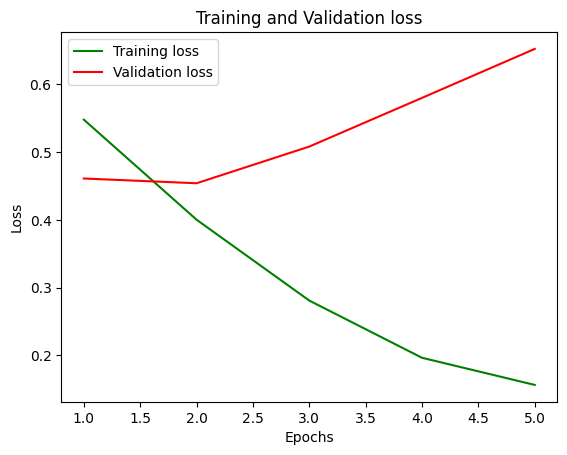

In [15]:
epochs = np.arange(1, n_epochs + 1)
plt.plot(epochs, train_losses, "g", label="Training loss")
plt.plot(epochs, val_losses, "r", label="Validation loss")
plt.title("Training and Validation loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.show()

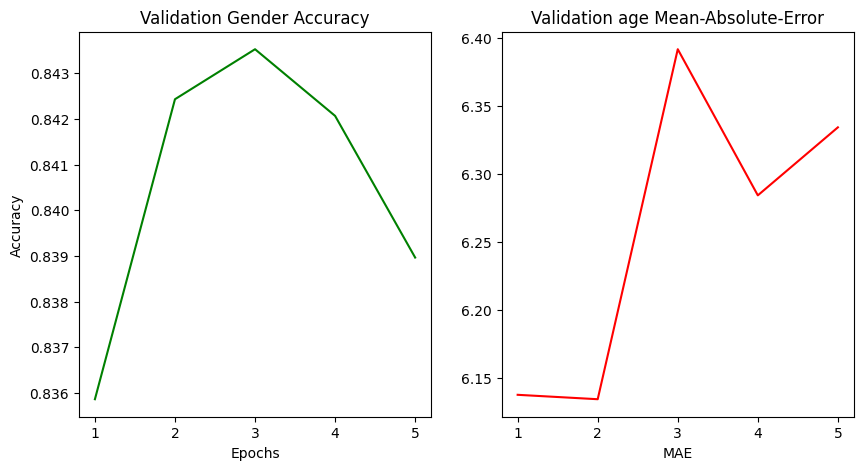

In [24]:
epochs = np.arange(1, n_epochs + 1)
fig, ax = plt.subplots(1, 2, figsize=(10, 5))
ax = ax.flat
ax[0].plot(epochs, [v.item() for v in val_gender_accuracies], "g")
ax[1].plot(epochs, [v.item() for v in val_age_maes], "r")
ax[0].set_xlabel("Epochs")
ax[1].set_xlabel("Epochs")
ax[0].set_ylabel("Accuracy")
ax[1].set_xlabel("MAE")
ax[0].set_title("Validation Gender Accuracy")
ax[1].set_title("Validation age Mean-Absolute-Error")
plt.show()

predicted gender: Male ; Predicted age: 33


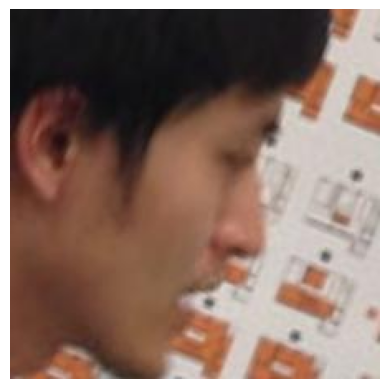

predicted gender: Female ; Predicted age: 35


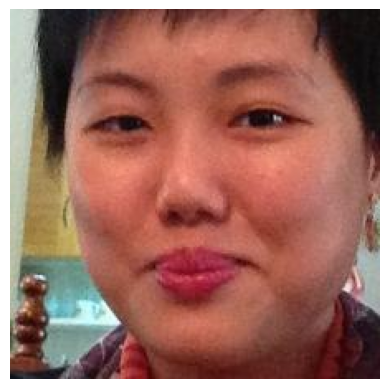

predicted gender: Female ; Predicted age: 39


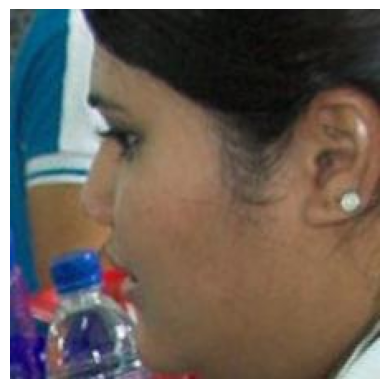

In [62]:
root_dir_val = "./data/Age_Gender_data/val/"
for i in range(3):
      img_path = random.choice(os.listdir(root_dir_val))
      im = cv2.imread(root_dir_val + img_path)
      im = trn.preprocess_image(im).to(device)
      gender, age = SNet(im)
      pred_gender = gender.to("cpu").detach().numpy()
      pred_age = age.to("cpu").detach().numpy()
      im_ = cv2.imread(root_dir_val + img_path)
      im_ = cv2.cvtColor(im_, cv2.COLOR_BGR2RGB)
      print("predicted gender:", np.where(pred_gender[0][0]<0.5, "Male", "Female"),
            "; Predicted age:", int(pred_age[0][0]*80))
      plt.figure()
      plt.imshow(im_)
      plt.axis("off")
      plt.show()